**Author: Zhonghua Zheng (zzheng25@illinois.edu, GitHub: zzheng93)**

Response:   
"TREFHTMX": Maximum reference height temperature over output period  

Features:   
"PRECT": Total (convective and large-scale) precipitation rate (liq + ice)  
"WSPDSRFAV": Horizontal total wind speed average at the surface  
"TS": Surface temperature (radiative)  
"TREFHT": Reference height temperature    


```bash
git clone http://github.com/dask/dask-tutorial
cd dask-tutorial
conda env create -f binder/environment.yml 
conda activate dask-tutorial
conda install xarray cftime=1.0.3.4
conda install -c conda-forge dask-ml dask-xgboost
```


# Load libraries

In [1]:
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from dask_ml.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

import dask
import xgboost
import dask_xgboost
from dask.distributed import Client

client = Client()
s3 = s3fs.S3FileSystem(anon=True)

In [2]:
client

Client Scheduler: tcp://127.0.0.1:34195 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 32.66 GB


# Load Data

In [3]:
%%time
zarr_ls = [xr.open_zarr(s3fs.S3Map(root="ncar-cesm-lens/atm/daily/cesmLE-RCP85-"+var+".zarr", s3=s3))[var]
           .sel(member_id=1,time="2010-01-01") 
           for var in ["TREFHT","TREFHTMX","PRECT","TS","WSPDSRFAV"]]  # read data from s3

CPU times: user 6.55 s, sys: 308 ms, total: 6.85 s
Wall time: 1min 34s


In [4]:
dddf=xr.merge(zarr_ls).to_dask_dataframe()  # merge arrays and convert to dask dataframe

In [5]:
X=dddf[["TREFHT","PRECT","TS","WSPDSRFAV"]]  # features
Y=dddf["TREFHTMX"]  # response

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)  # split into training and testing

# Train the XGB model

In [7]:
%%time
params = {'objective': 'reg:squarederror',
          'max_depth': 6, 'eta': 0.01}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=500)

CPU times: user 306 ms, sys: 57.8 ms, total: 364 ms
Wall time: 13 s


## Determine feature importance

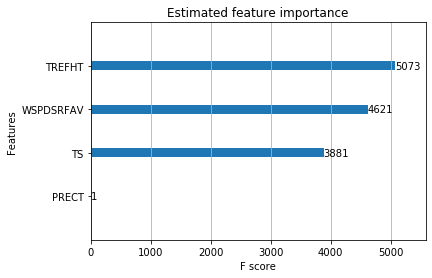

In [8]:
%matplotlib inline
ax = xgboost.plot_importance(bst)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

# Test model performance

In [9]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_test, y_hat = dask.compute(y_test, y_hat)

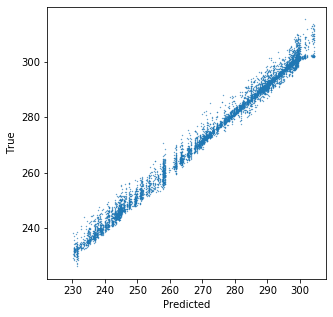

rmse: 2.5904884
r2_score: 0.98544579149015


In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_hat,y_test,s=0.1)
ax.plot([y_test.min(), y_test.min()], [y_test.max(), y_test.max()],c="black")
ax.set(
    xlabel="Predicted",
    ylabel="True",
)
plt.show()
print("rmse:",np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
print("r2_score:",metrics.r2_score(y_test,y_hat))